In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from tensorflow.keras.applications import *
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
#import tensorflow_datasets as tfds
#import tensorflow_hub as hub
#mport tensorflow_addons as tfa
from time import time
import glob, warnings
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from PIL import Image

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split


# Load the data and labels from the saved NumPy arrays
data_array = np.load('D:\WESAD_code\WESAD_DATA_LABELSARRAY_FINAL\Subject_array\data_array.npy')
labels_array = np.load('D:\WESAD_code\WESAD_DATA_LABELSARRAY_FINAL\Labels_array\label_array.npy')

In [3]:
print(data_array.shape)
print(labels_array.shape)

(16492, 224, 224, 3)
(16492, 3)


In [4]:
####SEED_0

import numpy as np
from sklearn.model_selection import train_test_split

# Assuming the dataset is stored in the variable `data_array` and the corresponding labels in `labels_array`

# Splitting the dataset into 75% training, 5% validation, and 20% testing
X_train_val, X_test, y_train_val, y_test = train_test_split(data_array, labels_array, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.0625, random_state=0)

# Checking the shape of each set
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (12368, 224, 224, 3)
Training labels shape: (12368, 3)
Validation data shape: (825, 224, 224, 3)
Validation labels shape: (825, 3)
Testing data shape: (3299, 224, 224, 3)
Testing labels shape: (3299, 3)


In [5]:
y_test

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19

IMG_SIZE = 224
n_CLASS = 3

pretrained_model = tf.keras.applications.VGG19(
            input_shape = (IMG_SIZE, IMG_SIZE, 3),
            include_top = False,
            weights='imagenet'
        )
pretrained_model.trainable = True

def create_model():
    x = pretrained_model.output
    x = GlobalAveragePooling2D()(x)
    # Add a fully connected layer
    x = Dense(128, activation='relu')(x)
    # Add a final softmax layer
    predictions = Dense(n_CLASS, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=pretrained_model.input, outputs=predictions)

    return model

leaf_model = create_model()

In [7]:
leaf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

leaf_model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.0001),
              metrics = 'accuracy')


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 1,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-7,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath ='./Vgg19_model1_TRUE0.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')


In [9]:
import time
import tensorflow as tf

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        epoch_time_end = time.time()
        elapsed_time = epoch_time_end - self.epoch_time_start
        self.times.append(elapsed_time)

In [10]:
int_epoch = 15
time_callback = TimeHistory()
callbacks = [earlystopping, reduce_lr, checkpointer, time_callback]

history = leaf_model.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        epochs=int_epoch,
        callbacks=callbacks
    )

Epoch 1/15
387/387 [==============================] - ETA: 0s - loss: 5.3234 - accuracy: 0.5301 
Epoch 1: val_accuracy improved from -inf to 0.51879, saving model to .\Vgg19_model1_TRUE0.hdf5
387/387 [==============================] - 4584s 12s/step - loss: 5.3234 - accuracy: 0.5301 - val_loss: 1.0171 - val_accuracy: 0.5188 - lr: 0.0010
Epoch 2/15
387/387 [==============================] - ETA: 0s - loss: 0.9958 - accuracy: 0.5337 
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 2: val_accuracy did not improve from 0.51879
387/387 [==============================] - 4646s 12s/step - loss: 0.9958 - accuracy: 0.5337 - val_loss: 1.0187 - val_accuracy: 0.5188 - lr: 0.0010
Epoch 3/15
387/387 [==============================] - ETA: 0s - loss: 0.9941 - accuracy: 0.5337 
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 3: val_accuracy did not improve from 0.51879
387/387 [==============================] - 4646s 12s/step - lo

In [11]:
print("Not using Gradient Centralization:")
print(f"Loss: {history.history['loss'][-1]}")
print(f"accuracy: {history.history['accuracy'][-1]}")
print(f"Validation accuracy: {history.history['val_accuracy'][-1]}")
print(f"Training Time: {sum(time_callback.times)} seconds")

Not using Gradient Centralization:
Loss: 0.9937536716461182
accuracy: 0.5337160229682922
Validation accuracy: 0.5187878608703613
Training Time: 27766.220620155334 seconds


In [12]:
acc = history.history['accuracy']
print(max(acc))

0.5337160229682922


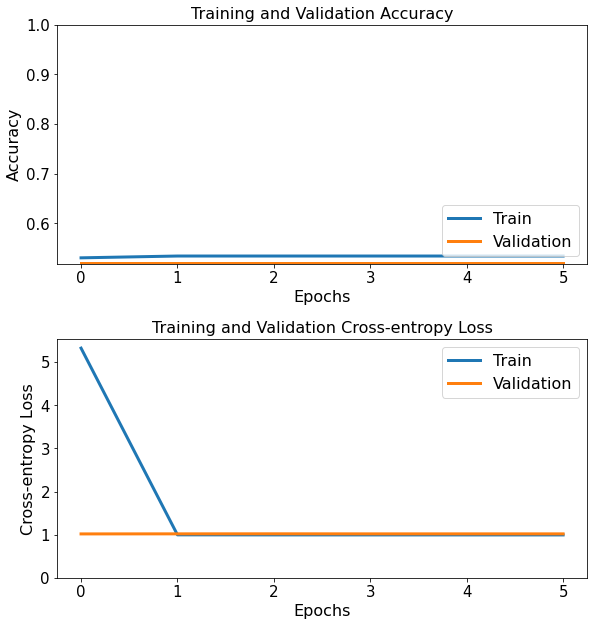

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(9, 9))
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3.0)
plt.plot(acc, label='Train' , linewidth = 3)
plt.plot(val_acc, label='Validation', linewidth = 3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='lower right' , prop={'size': 16})
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy' , fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize=16)

plt.subplot(2, 1, 2)
plt.tight_layout(pad=3.0)
plt.plot(loss, label='Train', linewidth = 3)
plt.plot(val_loss, label='Validation', linewidth = 3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', prop={'size': 16})
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Cross-entropy Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Cross-entropy Loss', fontsize=16)
plt.show()

In [14]:
def load_trained_model(weights_path):
   model = create_model()
   model.load_weights(weights_path)
   return model

In [15]:
new_model = load_trained_model('D:\WESAD_code\Vgg19_model1_TRUE0.hdf5')
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [16]:
from sklearn.metrics import classification_report

y_pred = new_model.predict(X_val)
y_predargmax = np.argmax(y_pred, axis=1)
y_true = y_val

y_pred_categorical = np.zeros_like(y_true)
y_pred_categorical[np.arange(len(y_predargmax)), y_predargmax] = 1


clreport = classification_report(y_true, y_pred_categorical, digits=4)
print(clreport)

26/26 [==============================] - 76s 3s/step
              precision    recall  f1-score   support

           0     0.5188    1.0000    0.6832       428
           1     0.0000    0.0000    0.0000       239
           2     0.0000    0.0000    0.0000       158

   micro avg     0.5188    0.5188    0.5188       825
   macro avg     0.1729    0.3333    0.2277       825
weighted avg     0.2691    0.5188    0.3544       825
 samples avg     0.5188    0.5188    0.5188       825



**Testing**

In [17]:
from sklearn.metrics import accuracy_score, classification_report

y_predt = new_model.predict(X_test)
y_predargmaxt = np.argmax(y_predt, axis=1)
y_truet = y_test

# Assuming y_predargmax and y_test are already defined
y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to integer labels
test_accuracy = accuracy_score(y_test_labels, y_predargmaxt)
print("Test Accuracy:", test_accuracy)

y_pred_categoricalt = np.zeros_like(y_truet)
y_pred_categoricalt[np.arange(len(y_predargmaxt)), y_predargmaxt] = 1


clreportt = classification_report(y_truet, y_pred_categoricalt, digits=4)
print(clreportt)

104/104 [==============================] - 311s 3s/step
Test Accuracy: 0.5298575325856321
              precision    recall  f1-score   support

           0     0.5299    1.0000    0.6927      1748
           1     0.0000    0.0000    0.0000       989
           2     0.0000    0.0000    0.0000       562

   micro avg     0.5299    0.5299    0.5299      3299
   macro avg     0.1766    0.3333    0.2309      3299
weighted avg     0.2807    0.5299    0.3670      3299
 samples avg     0.5299    0.5299    0.5299      3299



In [18]:
import os
os.chdir(r'D:\WESAD_code')
r'Vgg19_model1_TRUE0.hdf5'

'Vgg19_model1_TRUE0.hdf5'

In [19]:
from IPython.display import FileLink
FileLink(r'Vgg19_model1_TRUE0.hdf5')

D:\WESAD_code\Vgg19_model1_TRUE0.hdf5